In [2]:
# Random Forest Algorithm

In [127]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [129]:
shipping_data = pd.read_csv("ShippingData1.csv")

In [131]:
shipping_data

,CONTAINER_ID,LINE_CODE,CONTAINER_DATE,DATE,DAY,TIME,AM/PM,CONTAINER_TYPE_CODE,CONTAINER_TYPE,CONTAINER_ISO_CODE,CONTAINER_LENGTH,CONTAINER_HEIGHT,CONTAINER_WIDTH,VENTILATION,DANGEROUS_TRANSPORT,DESIGNATION_CODE,DESIGNATION,TIME_24HR
0,TRLU5869252,HLL,2/3/2024 0:01,2/3/2024,Saturday,12:01:00,AM,HC,High Cubed,45G1,40,9'6'',8,No Ventilation,No,MT,Empty,00:01:00
1,WIKU5201240,MLH,6/21/2024 12:34,6/21/2024,Friday,12:34:00,PM,HC,High Cubed,45G1,40,9'6'',8,No Ventilation,No,EXP,Export Service,12:34:00
2,ESDU4075587,ESL,7/15/2024 12:21,7/15/2024,Monday,12:21:00,PM,HC,High Cubed,45G1,40,9'6'',8,No Ventilation,No,T/S,Transhipment,12:21:00
3,WFHU5195877,ESL,7/15/2024 12:21,7/15/2024,Monday,12:21:00,PM,HC,High Cubed,45G1,40,9'6'',8,No Ventilation,No,T/S,Transhipment,12:21:00
4,GCSU2021209,NVSL,8/3/2024 10:15,8/3/2024,Saturday,10:15:00,AM,STD,Standard,22G1,20,8'6'',8,No Ventilation,No,EXP,Export Service,10:15:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,CSDU3426685,MSK,10/18/2024 8:43,10/18/2024,Friday,8:43:00,AM,STD,Standard,22G1,20,8'6'',8,No Ventilation,No,EXP,Export Service,08:43:00
996,TSLU0510425,TLPL,10/18/2024 9:17,10/18/2024,Friday,9:17:00,AM,HC,High Cubed,4500,40,9'6'',8,No Ventilation,No,T/S,Transhipment,09:17:00
997,TXGU8059404,YML,10/18/2024 10:26,10/18/2024,Friday,10:26:00,AM,HC,High Cubed,4500,40,9'6'',8,No Ventilation,No,MT,Empty,10:26:00
998,WFHU1306062,YML,10/18/2024 10:26,10/18/2024,Friday,10:26:00,AM,STD,Standard,2200,20,8'6'',8,No Ventilation,No,MT,Empty,10:26:00


In [133]:
def assign_time_window(time):
    hour = int(time.split(":")[0])
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 24:
        return "Evening"
    else:
        return "Night"

shipping_data['Time Window'] = shipping_data['TIME_24HR'].apply(assign_time_window)

In [135]:
shipping_data['Time Window']

0          Night
1      Afternoon
2      Afternoon
3      Afternoon
4        Morning
         ...    
995      Morning
996      Morning
997      Morning
998      Morning
999      Morning
Name: Time Window, Length: 1000, dtype: object

In [137]:
# Encode categorical features
label_encoders = {}
for column in ['DAY', 'CONTAINER_TYPE', 'Time Window', 'DESIGNATION', 'VENTILATION']:
    le = LabelEncoder()
    shipping_data[column] = le.fit_transform(shipping_data[column])
    label_encoders[column] = le

In [139]:
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['CONTAINER_LENGTH']
shipping_data[numerical_features] = scaler.fit_transform(shipping_data[numerical_features])

# Define input features and target variable
X = shipping_data[['DAY', 'CONTAINER_TYPE', 'VENTILATION', 'DESIGNATION', 'CONTAINER_LENGTH']]
y = shipping_data['Time Window']  # Target is the time window

In [141]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
# Train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [145]:
# Evaluate
y_pred = knn.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[52  4 18  1]
 [ 9 11  7  1]
 [40  3 49  0]
 [ 2  0  1  2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.69      0.58        75
           1       0.61      0.39      0.48        28
           2       0.65      0.53      0.59        92
           3       0.50      0.40      0.44         5

    accuracy                           0.57       200
   macro avg       0.57      0.50      0.52       200
weighted avg       0.59      0.57      0.57       200



In [147]:
# Tune k
k_values = range(1, 100)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

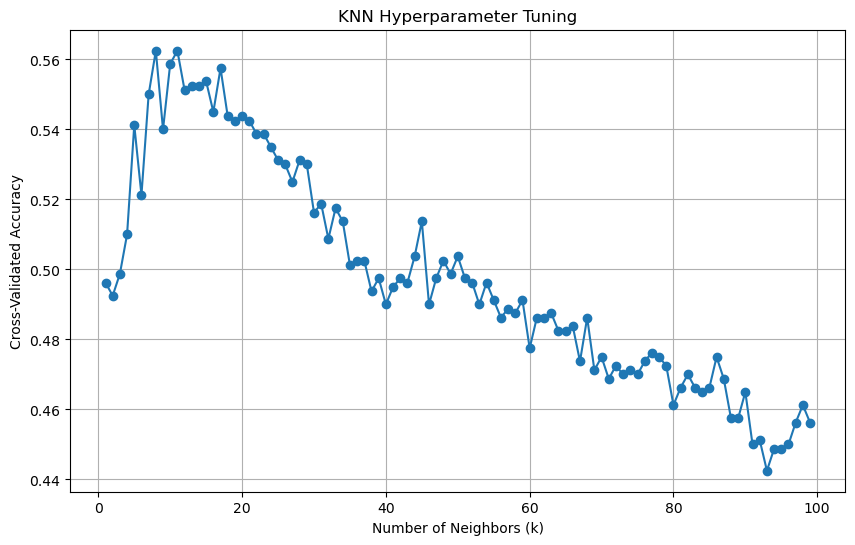

In [148]:
# Plot accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validated Accuracy")
plt.title("KNN Hyperparameter Tuning")
plt.grid()
plt.show()

In [149]:
# Optimal k
best_k = k_values[np.argmax(cv_scores)]
print(f"Optimal number of neighbors: {best_k}")

Optimal number of neighbors: 8


In [150]:
# Train KNN
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [155]:
# Evaluate
y_pred = knn.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.71      0.60        75
           1       0.56      0.36      0.43        28
           2       0.64      0.53      0.58        92
           3       0.50      0.40      0.44         5

    accuracy                           0.57       200
   macro avg       0.55      0.50      0.52       200
weighted avg       0.58      0.57      0.56       200



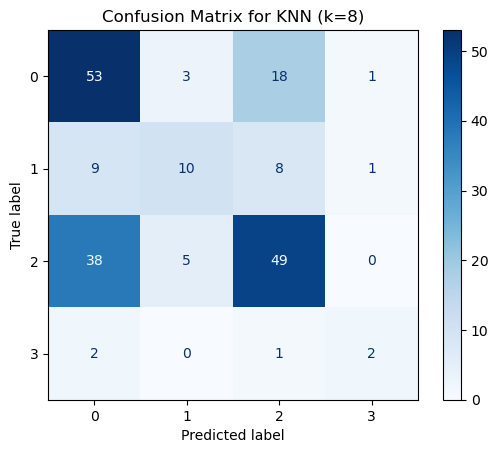

In [159]:
# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=knn.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for KNN (k=8)")
plt.show()